# Trying out sympy module

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sympy as sp
import numpy as np
from Modules.sympy.classes import *
from Modules.sympy.utils import *
from sympy.physics.quantum import Dagger
from Modules.sympy.solver import *

In [ ]:
Spin = RDBasis("\\sigma", 'spin', dim=2)
sx = Spin.project(sp.Matrix([[0, 1], [1, 0]]))
sz = Spin.project(sp.Matrix([[1, 0], [0, -1]]))

a = RDBoson("a", subspace ="b")
ad = RDBoson("{a^\\dagger}", subspace ="b", is_annihilation=False)

hbar = RDsymbol("hbar", order = 0)
omega = RDsymbol("omega", order = 0)
Omega_z = RDsymbol("\\Omega_{z}", order = 0)
g = RDsymbol("g", order = 1)

H = hbar * omega * ad * a + hbar * Omega_z * sp.Rational(1,2) * sz - hbar * g * (a + ad) * sx
H

In [ ]:
from IPython.display import display, Math
def display_dict(d):
    for k, v in d.items():
        display(Math(f"{sp.latex(k)} = {sp.latex(v)}"))

In [ ]:
S, H_diagonal, H_block = solver(H, Spin, order=2)

In [ ]:
H_block

# Extra

In [ ]:
def create_equations_by_order(H, order=2):
    max_order = max(list(group_by_order(H).keys()))

    terms = [RDsymbol(f'\\varepsilon^{{({k})}}', order=k)*RDOperator(f'H_{{{k}}}', dim=2, subspace='RD', matrix=sp.eye(2)) for k in range(1, max_order+1)]
    H_aux = RDOperator(f'H_{{{0}}}', dim=2, subspace='RD', matrix=sp.eye(2))  + sum(terms)
    

    s_symbols = [RDsymbol(f'\\varepsilon^{{({k})}}', order=k) for k in range(1, order+1)]
    s_terms = [s_symbols[k-1]*RDOperator(f'S_{{{k}}}', dim=2, subspace='RD', matrix=sp.eye(2)) for k in range(1, order+1)]
    S = sum(s_terms)

    expanded_equations = 0
    for k in range(order+1):
        expanded_equations += (sp.Rational(1, sp.factorial(k)) * expand_commutator(nested_commutator(H_aux, S, k))).expand()
    
    terms = expanded_equations.as_ordered_terms()
    factors = [sp.Mul(*term.as_ordered_factors()[:-1]) for term in terms]
    
    subs_epsilons = {s_k: 1 for s_k in s_symbols}

    factors_order = {}
    for i, f in enumerate(factors):
        order_dict = group_by_order(f)
        if not isinstance(order_dict, dict):
            order_index = order_dict
            if order_index > order:
                continue
            factors_order[order_index] = factors_order.get(order_index, 0) + terms[i].subs(subs_epsilons)
            continue
        order_index = list(order_dict.keys())[0]
        if order_index > order:
            continue
        factors_order[order_index] = factors_order.get(order_index, 0) + terms[i].subs(subs_epsilons)
        
    return factors_order

In [51]:
def generate_keys(order):
    keys = [] # will contain keys
    
    def deapth_first_search(current_key, current_sum):
        if current_sum > order: # if current_sum is bigger than order
            return # return nothing
        if current_key: # if current key is not empty
            keys.append(current_key[:]) # append current key to keys
        start = 0 if not current_key else 1 # if current key is empty, start the next number from 0, else from 1
        for i in range(start, order + 1): # looping over values between start and order
            current_key.append(i) # append current number to the key
            deapth_first_search(current_key, current_sum + i) # recurse down the tree
            current_key.pop() # backtrack

            
            
    deapth_first_search([], 0) # start search with inital sum to zero
    return keys

def rearrange_sublists(sublists):
    # Step 1: Sort sublists based on the sum of their entries in increasing order
    sublists_sorted_by_sum = sorted(sublists, key=lambda sublist: sum(sublist))

    # Step 2: Group sublists with the same sum
    from collections import defaultdict
    sum_groups = defaultdict(list)
    for sublist in sublists_sorted_by_sum:
        sum_groups[sum(sublist)].append(sublist)

    # Step 3: Sort sublists within each sum group by their length in decreasing order
    for key in sum_groups:
        sum_groups[key].sort(key=lambda x: len(x), reverse=True)

    # Step 4: Flatten the sorted groups into a single list
    rearranged_sublists = []
    for key in sorted(sum_groups.keys()):  # iterate over sorted keys (sums)
        rearranged_sublists.extend(sum_groups[key])

    return rearranged_sublists

def custom_sort_key(sublist):
    """
    Custom sorting key function:
    - First, sorts by the sum of sublist elements in increasing order.
    - Second, sorts sublists with equal sums by moving sublists of length 2 containing a 0 in the first element to the bottom.
    """
    sublist_sum = sum(sublist)
    sublist_length = len(sublist)

    if sublist_length == 2 and sublist[0] == 0:
        # Ensure sublists of length 2 with a 0 in the first element go to the bottom
        return (sublist_sum, 1)
    else:
        return (sublist_sum, 0)

def rearrange_sublists(list_of_sublists):
    # Sort sublists based on custom key
    sorted_sublists = sorted(list_of_sublists, key=custom_sort_key)

    return sorted_sublists

keys = generate_keys(3)

rearrange_sublists(keys)

[[0],
 [1],
 [0, 1],
 [0, 1, 1],
 [1, 1],
 [2],
 [0, 2],
 [0, 1, 1, 1],
 [0, 1, 2],
 [0, 2, 1],
 [1, 1, 1],
 [1, 2],
 [2, 1],
 [3],
 [0, 3]]

<IPython.core.display.Javascript object>


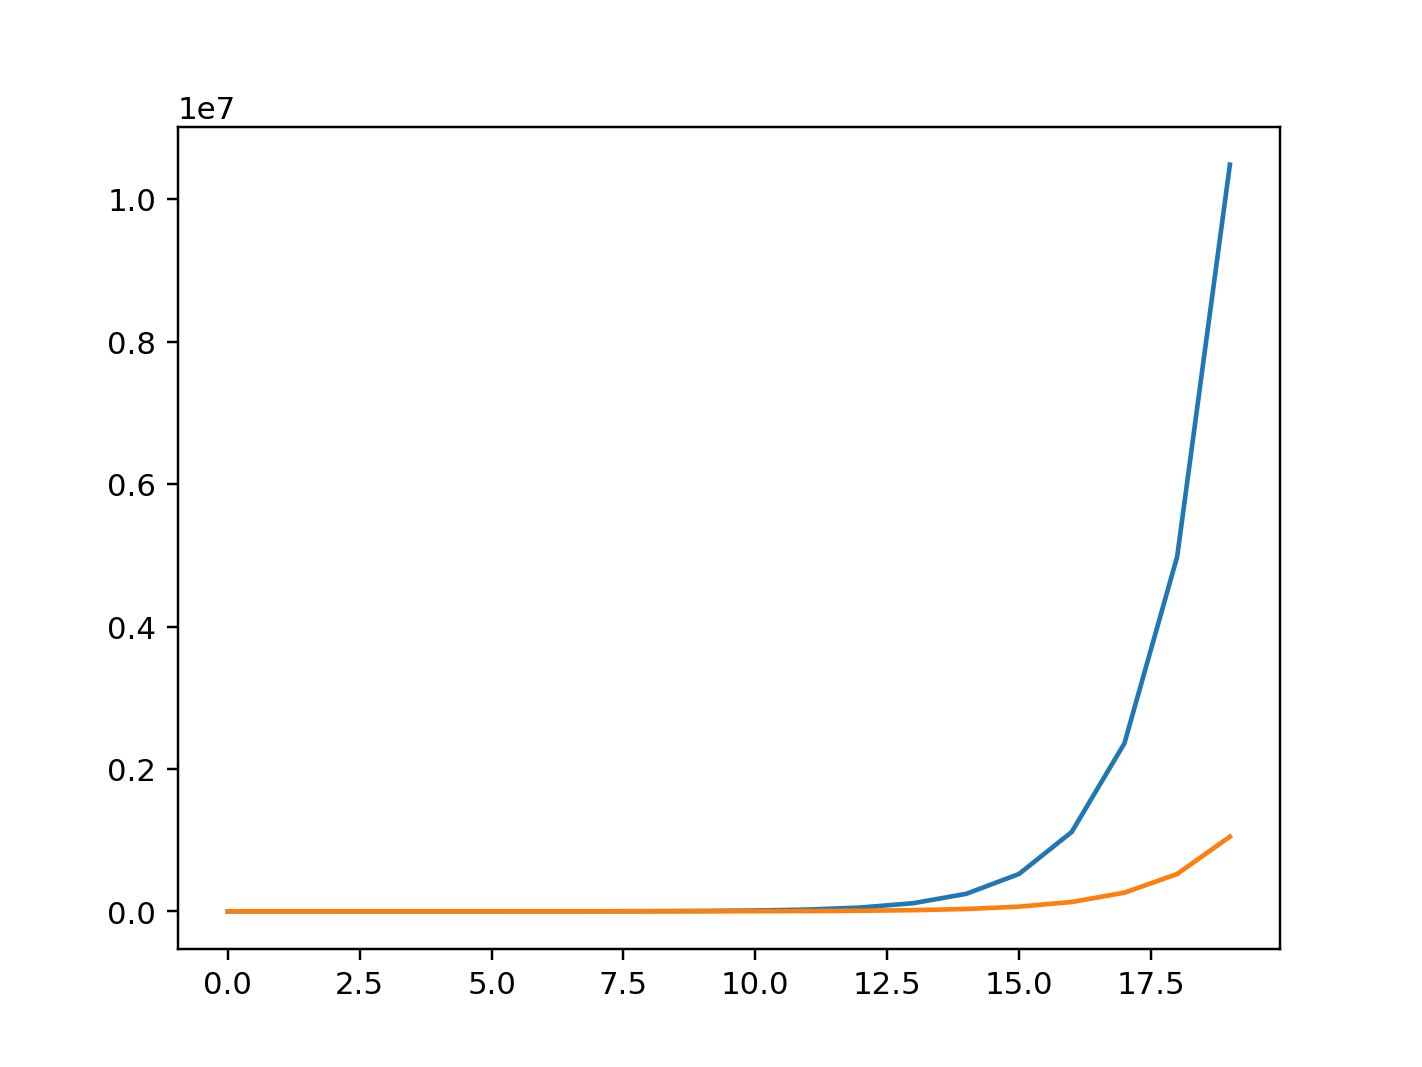

In [42]:
%matplotlib notebook
import matplotlib.pyplot as plt
def count_full_complexity(keys):
    count = 0
    for key in keys:
        if len(key) > 1:
            count += len(key)
    return count

def count_simplified_complexity(keys):
    count = 0
    for key in keys:
        if len(key) > 1:
            count +=1
    return count


full = []
simp = []

for order in range(20):
    full.append(count_full_complexity(generate_keys(order)))
    simp.append(count_simplified_complexity(generate_keys(order)))
plt.plot(range(20), full)
plt.plot(range(20), simp)